# E-tivity 4: CS5062 Overfitting and How to Prevent It 

## Name: Martin Power
## ID      : 9939245

# Lab 4: Comparison of Classifiers

This notebook demonstrates how to choose the best out of a few alternative classification models by applying cross-validation and comparing the accuracy of prediction, the F1-scores and the ROC curves of the classification models.

Here we use a _modified version_ of the __seeds data set__ (see https://archive.ics.uci.edu/ml/datasets/seeds), which is one of the public UCI data sets. Each example is a seed described by a few numerical attributes. The target variable for classification (in this example) is the type of the seed, which can be either 1 or 0. Class 1 are the seeds of a particular type that, we can assume, is important to learn to predict correctly, while class 0 are all other seeds.

In this example, we use 5-fold cross-validation. Empirical evidence suggests that 10 folds are probably the best choice for cross-validation, i.e. 10-fold cross-validation. However, since this data set is relatively small, and 1/10 of it is only 21 examples, it is sensible to use larger folds for testing. Thus, we demonstrate the comparison of classifiers with 5-fold cross-validation.

The code in this notebook was originally inspired by the example at https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html.

## A. Preparation

### Import Python modules

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

from scipy import interp

# Additional imports added for Etivity
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### Import evaluation and plotting functions

In [77]:
%run ./Lab4_Functions.ipynb

### Load and prepare the dataset for training and evaluating a classifier
Feel free to apply any other pre-processing technique at this point.

In [3]:
lab4_df = pd.read_csv("./seeds_dataset_binary.csv")
lab4_df.describe()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,0.333333
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.472531
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,0.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,0.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,0.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,1.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,1.000000


In [4]:
# target attribute
target = lab4_df['type']

# predictor attributes
predictors = lab4_df.drop('type', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### Prepare an array of 100 equally spaced false-positive-rate values between 0 and 1
To be used as an x-axis in ROC curve plots.

In [5]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

## B. Evaluation and Comparison of Classifiers

### Train a Probablistic SVM Classifier

In [6]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM = evaluate_classifier(folds=5, 
                                                                        p=predictors, t=target, 
                                                                        classifier=SVM_classifier, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C

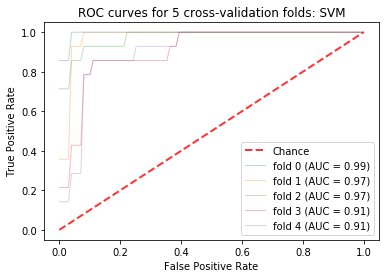

In [7]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

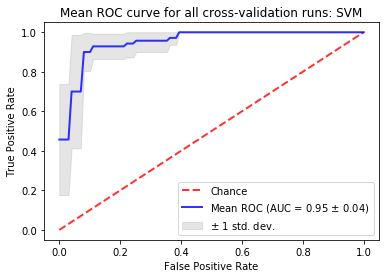

In [8]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

### Train a Naive Bayes Classifier

In [9]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_NB, f1_scores_NB, tprs_NB, aucs_NB = evaluate_classifier(folds=5, 
                                                                    p=predictors, t=target, 
                                                                    classifier=NB_classifier, 
                                                                    mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

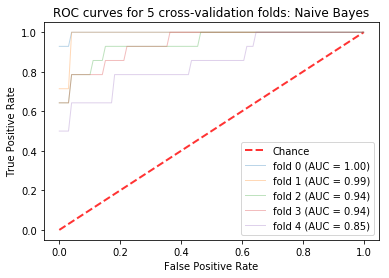

In [10]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

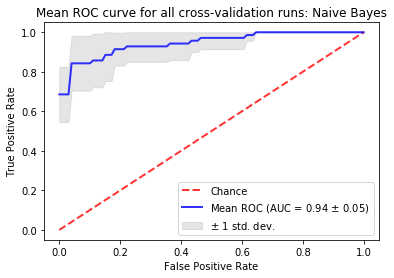

In [11]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

### Compare All Trained Classifiers

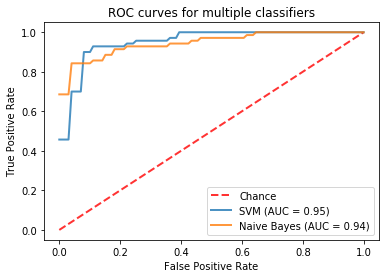

In [12]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB)]), 
                              np.array(['SVM', 'Naive Bayes']))

In [13]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB})

In [14]:
accuracies_df.describe()

,SVM,Naive Bayes
count,5.000000,5.000000
mean,0.876190,0.880952
std,0.045799,0.078967
min,0.809524,0.761905
25%,0.857143,0.857143
50%,0.880952,0.880952
75%,0.904762,0.952381
max,0.928571,0.952381


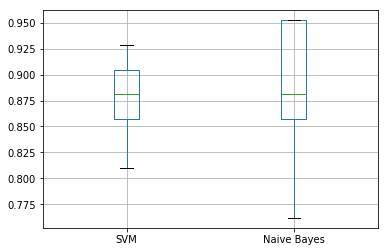

In [15]:
accuracies_df.boxplot()

In [16]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 'Naive Bayes' : f1_scores_NB})

In [17]:
f1_scores_df.describe()

,SVM,Naive Bayes
count,5.000000,5.000000
mean,0.804812,0.824418
std,0.056227,0.116353
min,0.750000,0.642857
25%,0.769231,0.800000
50%,0.782609,0.827586
75%,0.833333,0.923077
max,0.888889,0.928571


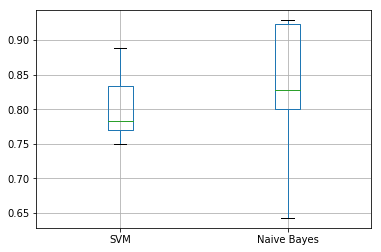

In [18]:
f1_scores_df.boxplot()

#### Conclusion

In this example, both the SVM and the Naive Bayes classifiers have mean accuracy approximately 88%, which is quite high. The ROC curves do not suggest a clear winner, although it can be noted that Naive Bayes can achieve TPR above 80% for a lower FPR than SVM. On the other hand, the accuracy of the five folds of Naive Bayes show higher variance than the accuracy of the five folds of SVM, and low variance is desirable. Still, the lowest accuracy of Naive Bayes is above 75% which is not bad. Similar observation can be made about the F1 score. Naive Bayes has a higher mean F1 score but also higher variance. Since both SVM and Naive Bayes have high mean accuracy, high mean F1 score and a very similar AUC, while SVM appears to have visibly lower variance than Naive Bayes, we can conclude that perhaps SVM is a safer choice for a best model. 

It will be interesting to plot precision and recall for a more detailed comparison. Since the two classes are not well balanced (1/3 of the examples are in class 1), a precision-recall curve a more detailed study of the precision and recall can provide better information than the ROC curves for picking the best model.

## C. FInal Model

Assuming SVM was chosen, now we can train a final (to be potentially deployed) SVM model with the whole dataset:

In [19]:
# model = NB_classifier.fit(predictors, target) 
model = SVM_classifier.fit(predictors, target) 

C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Use the model to predict the type of three new seeds:

In [20]:
new_seeds = np.array([[0.4,0.5,0.6,0.5,0.5,0.2,0.3], [0.0,1.0,0.0,1.0,0.5,0.5,0.2], [0.2,0.2,0.2,1.0,0.2,0.2,0.2]])

In [21]:
# Probabilistic prediction
np.round(model.predict_proba(new_seeds), 2)
# Note: 
#   - the first column are the probabilities for the three new seeds to belong to class 0
#   - the second column are the probabilities for the three new seeds to belong to class 1

array([[0.06, 0.94],
       [0.91, 0.09],
       [0.37, 0.63]])

In [22]:
# Exact prediction
model.predict(new_seeds)

array([1, 0, 0], dtype=int64)

# Comparison with Loans Dataset

### Load and prepare the dataset for training and evaluating a classifier
Feel free to apply any other pre-processing technique at this point.

In [23]:
loans_df = pd.read_csv("./loans_et4.csv")
loans_df.describe(include='all')

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.797917,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [24]:
# target attribute
target = loans_df['Loan_Status']

# predictor attributes
predictors = loans_df.drop('Loan_Status', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### Prepare an array of 100 equally spaced false-positive-rate values between 0 and 1
To be used as an x-axis in ROC curve plots.

In [25]:
mean_fpr = np.linspace(start=0, stop=1, num=100) # MPP TODO Thisline is redundant - could reuse from existing cell

## B. Evaluation and Comparison of Classifiers

### Set Number of Folds To Use

In [26]:
# Seeds dataset only had 210 entries so folds was restricted to 5
# Loans dataset has 480 entries so it may be possible to use 10 folds
# Using variable to allow folds to be easily varied and impact on performance observed
loan_folds = 10

### Train a Probablistic SVM Classifier

In [27]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM = evaluate_classifier(folds=loan_folds, 
                                                                        p=predictors, t=target, 
                                                                        classifier=SVM_classifier, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C

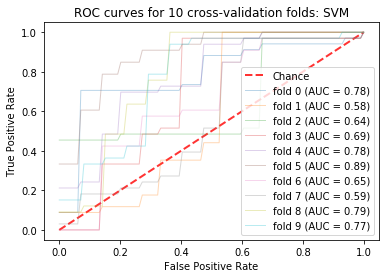

In [28]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

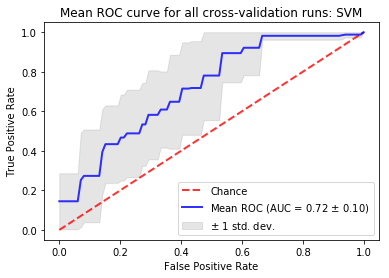

In [29]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

### Train a Naive Bayes Classifier

In [30]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_NB, f1_scores_NB, tprs_NB, aucs_NB = evaluate_classifier(folds=loan_folds, 
                                                                    p=predictors, t=target, 
                                                                    classifier=NB_classifier, 
                                                                    mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

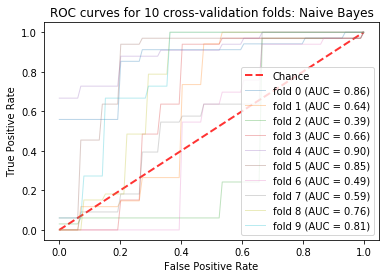

In [31]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

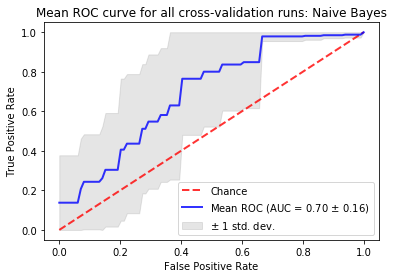

In [32]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

### Train an AdaBoost Classifier

In [33]:
from sklearn.ensemble import AdaBoostClassifier

In [34]:
AB_classifier = AdaBoostClassifier()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_AB, f1_scores_AB, tprs_AB, aucs_AB = evaluate_classifier(folds=loan_folds, 
                                                                        p=predictors, t=target, 
                                                                        classifier=AB_classifier, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

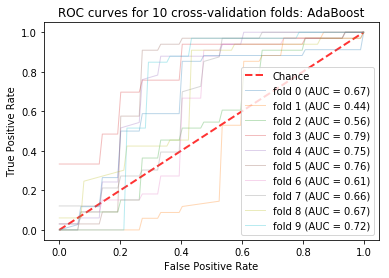

In [35]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_AB, aucs_AB, 'AdaBoost')

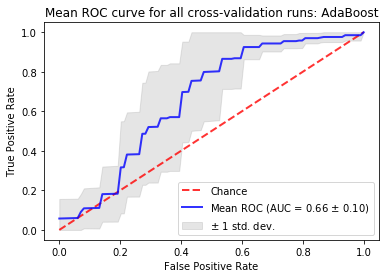

In [36]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_AB, aucs_AB, 'AdaBoost')

### Compare All Trained Classifiers

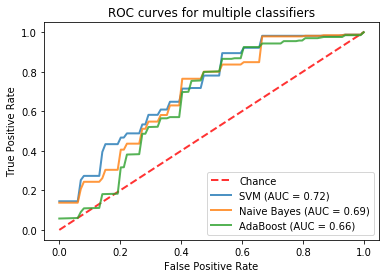

In [39]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0), np.mean(tprs_AB, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB), np.mean(aucs_AB)]), 
                              np.array(['SVM', 'Naive Bayes', 'AdaBoost']))

In [40]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_loans_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB, 'AdaBoost' : accuracies_AB})

In [43]:
accuracies_loans_df.describe()

,SVM,Naive Bayes,AdaBoost
count,10.000000,10.000000,10.000000
mean,0.808650,0.787732,0.779519
std,0.042218,0.079246,0.045352
min,0.755102,0.625000,0.708333
25%,0.770833,0.770833,0.759035
50%,0.803997,0.783588,0.789450
75%,0.846631,0.834998,0.791667
max,0.872340,0.893617,0.851064


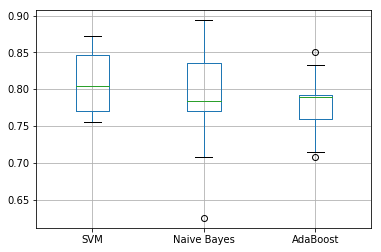

In [44]:
accuracies_loans_df.boxplot()

In [45]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_loans_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 'Naive Bayes' : f1_scores_NB, 'AdaBoost' : f1_scores_AB})

In [46]:
f1_scores_loans_df.describe()

,SVM,Naive Bayes,AdaBoost
count,10.000000,10.000000,10.000000
mean,0.876583,0.857474,0.850967
std,0.025271,0.055906,0.032107
min,0.842105,0.735294,0.805556
25%,0.854286,0.853039,0.829976
50%,0.875769,0.853333,0.852941
75%,0.898279,0.891641,0.866594
max,0.916667,0.929577,0.901408


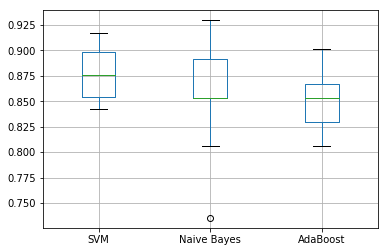

In [47]:
f1_scores_loans_df.boxplot()

#### Conclusion

In this example, both the SVM and the Naive Bayes classifiers have mean accuracy approximately 88%, which is quite high. The ROC curves do not suggest a clear winner, although it can be noted that Naive Bayes can achieve TPR above 80% for a lower FPR than SVM. On the other hand, the accuracy of the five folds of Naive Bayes show higher variance than the accuracy of the five folds of SVM, and low variance is desirable. Still, the lowest accuracy of Naive Bayes is above 75% which is not bad. Similar observation can be made about the F1 score. Naive Bayes has a higher mean F1 score but also higher variance. Since both SVM and Naive Bayes have high mean accuracy, high mean F1 score and a very similar AUC, while SVM appears to have visibly lower variance than Naive Bayes, we can conclude that perhaps SVM is a safer choice for a best model. 

It will be interesting to plot precision and recall for a more detailed comparison. Since the two classes are not well balanced (1/3 of the examples are in class 1), a precision-recall curve a more detailed study of the precision and recall can provide better information than the ROC curves for picking the best model.

## C. FInal Model

Assuming SVM was chosen, now we can train a final (to be potentially deployed) SVM model with the whole dataset:

In [101]:
model = NB_classifier.fit(predictors, target)

Use the model to predict the type of three new seeds:

In [102]:
new_seeds = np.array([[0.4,0.5,0.6,0.5,0.5,0.2,0.3], [0.0,1.0,0.0,1.0,0.5,0.5,0.2], [0.2,0.2,0.2,1.0,0.2,0.2,0.2]])

In [103]:
# Probabilistic prediction
np.round(model.predict_proba(new_seeds), 2)
# Note: 
#   - the first column are the probabilities for the three new seeds to belong to class 0
#   - the second column are the probabilities for the three new seeds to belong to class 1

ValueError: operands could not be broadcast together with shapes (3,7) (11,) 

In [ ]:
# Exact prediction
model.predict(new_seeds)

In [48]:
from sklearn.linear_model import LogisticRegression

In [52]:
LR_classifier = LogisticRegression(solver='lbfgs')

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_LR, f1_scores_LR, tprs_LR, aucs_LR = evaluate_classifier(folds=loan_folds, 
                                                                        p=predictors, t=target, 
                                                                        classifier=LR_classifier, 
                                                                        mean_fpr=mean_fpr)

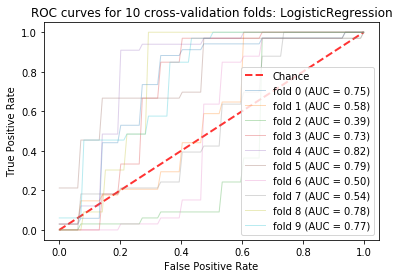

In [53]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_LR, aucs_LR, 'LogisticRegression')

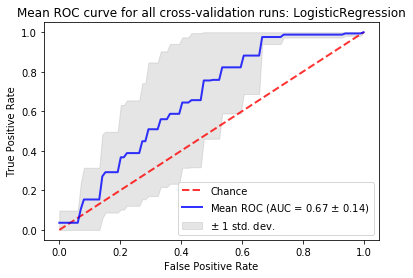

In [54]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_LR, aucs_LR, 'LogisticRegression')

In [159]:
## DEBUG Area

In [216]:
%run ./Lab4_Functions.ipynb

In [217]:
mean_tpr = np.linspace(start=0, stop=1, num=100)

In [222]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True)

accuracies_SVM, f1_scores_SVM, precisions_SVM, recalls_SVM, tprs_SVM, aucs_SVM, prcs_SVM, pr_aucs_SVM = evaluate_classifier_new(
                                                                        folds=loan_folds, 
                                                                        p=predictors, t=target, 
                                                                        classifier=SVM_classifier, 
                                                                        mean_fpr=mean_fpr,
                                                                        mean_tpr=mean_tpr)

C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C

In [223]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

accuracies_NB, f1_scores_NB, precisions_NB, recalls_NB, tprs_NB, aucs_NB, prcs_NB, pr_aucs_NB = evaluate_classifier_new(
                                                                        folds=loan_folds, 
                                                                        p=predictors, t=target, 
                                                                        classifier=NB_classifier, 
                                                                        mean_fpr=mean_fpr,
                                                                        mean_tpr=mean_tpr)

In [221]:
AB_classifier = AdaBoostClassifier()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_AB, f1_scores_AB, precisions_AB, recalls_AB, tprs_AB, aucs_AB, prcs_AB, pr_aucs_AB = evaluate_classifier_new(
                                                                        folds=loan_folds, 
                                                                        p=predictors, t=target, 
                                                                        classifier=AB_classifier, 
                                                                        mean_fpr=mean_fpr,
                                                                        mean_tpr=mean_tpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

In [224]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_loans_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB, 'AdaBoost' : accuracies_AB})

In [225]:
accuracies_loans_df.describe()

,SVM,Naive Bayes,AdaBoost
count,10.000000,10.000000,10.000000
mean,0.808650,0.787732,0.779519
std,0.042218,0.079246,0.045352
min,0.755102,0.625000,0.708333
25%,0.770833,0.770833,0.759035
50%,0.803997,0.783588,0.789450
75%,0.846631,0.834998,0.791667
max,0.872340,0.893617,0.851064


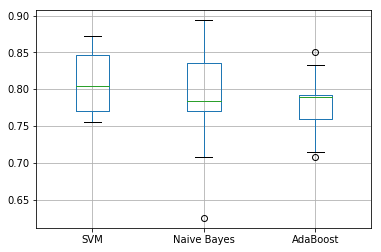

In [226]:
accuracies_loans_df.boxplot()

In [227]:
# Compare the statistics of the precisions across all cross-validation folds
precisions_loans_df = pd.DataFrame(data={'SVM' : precisions_SVM, 'Naive Bayes' : precisions_NB, 'AdaBoost' : precisions_AB})

In [236]:
# Determine No Skill Value
total_pos = ((target == 1).sum())
total_neg = ((target != 1).sum())

no_skill = total_pos/(total_pos+total_neg)

print("No Skill Level for This Dataset is:\t",no_skill)

No Skill Level for This Dataset is:	 0.6916666666666667


In [228]:
precisions_loans_df.describe()

,SVM,Naive Bayes,AdaBoost
count,10.000000,10.000000,10.000000
mean,0.794473,0.799070,0.798735
std,0.039146,0.054635,0.034343
min,0.750000,0.714286,0.743590
25%,0.761905,0.761905,0.769331
50%,0.779070,0.795006,0.807692
75%,0.836707,0.850000,0.827311
max,0.846154,0.868421,0.842105


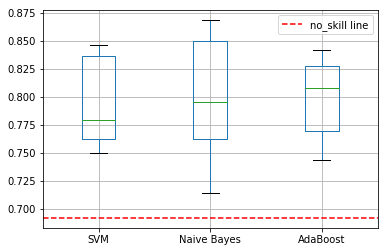

In [242]:
# Show the line of "no skill" on the boxplot
# "no skill" concept is taken from 
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
fig, ax = plt.subplots()
ax.axhline(no_skill, color='r', ls='--', label='no_skill line')
ax.legend()

precisions_loans_df.boxplot(ax=ax)

In [231]:
# Compare the statistics of the accuracies across all cross-validation folds
recalls_loans_df = pd.DataFrame(data={'SVM' : recalls_SVM, 'Naive Bayes' : recalls_NB, 'AdaBoost' : recalls_AB})

In [232]:
recalls_loans_df.describe()

,SVM,Naive Bayes,AdaBoost
count,10.000000,10.000000,10.000000
mean,0.978966,0.927451,0.913102
std,0.020076,0.074536,0.058228
min,0.941176,0.757576,0.823529
25%,0.969697,0.886364,0.878788
50%,0.969697,0.955437,0.909091
75%,1.000000,0.969697,0.962121
max,1.000000,1.000000,1.000000


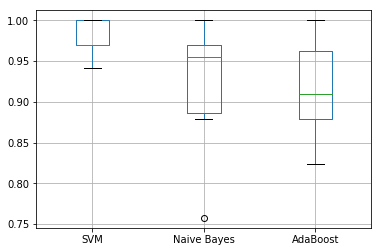

In [233]:
recalls_loans_df.boxplot()

No Skill =  0.6916666666666667


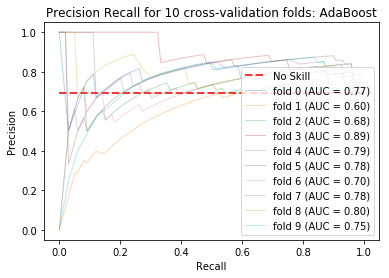

In [212]:
#print(prcs_AB)
# Plot a precision curve for each cross-validation fold
plot_pr_cv_folds(mean_tpr, prcs_AB, pr_aucs_AB, target, 'AdaBoost')

No Skill =  0.6916666666666667


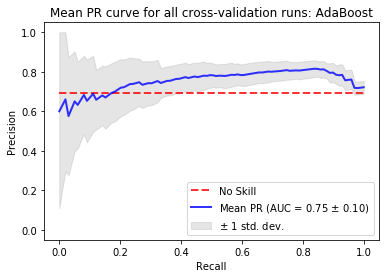

In [213]:
# Plot a mean ROC curve for all cross-validation runs
plot_pr_mean(mean_tpr, prcs_AB, aucs_AB, target, 'AdaBoost')

No Skill =  0.6916666666666667


IndexError: too many indices for array

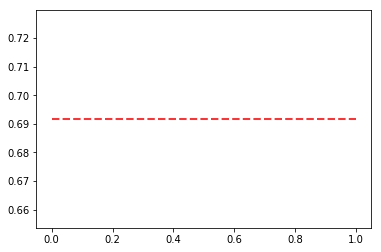

In [214]:
plot_pr_multiple_classifiers(mean_tpr, 
                              np.stack((np.mean(prcs_AB, axis=0))), 
                              np.array([np.mean(aucs_AB)]), 
                              target,
                              np.array(['SVM', 'Naive Bayes', 'AdaBoost']))

In [82]:
def plot_pr_cv_folds_dbg(mean_tpr, prcs, aucs, target, classifier_name):
    
    # Determine No Skill Value
    total_pos = ((target == 1).sum())
    total_neg = ((target != 1).sum())
    
    no_skill = total_pos/(total_pos+total_neg)
    
    plt.plot([0, no_skill], [1, no_skill], linestyle='--', lw=2, color='r', label='No Skill', alpha=.8)
    
    for i in range(0, aucs.shape[0]):
        plt.plot(mean_tpr, prcs[i,:], lw=1, alpha=0.3,label='fold %d (AUC = %0.2f)' % (i, aucs[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall for %d cross-validation folds: %s' % (aucs.shape[0], classifier_name))
    plt.legend(loc="lower right")
    plt.show()

In [86]:
print(pr_aucs_AB.shape)

(11,)


IndexError: index 10 is out of bounds for axis 0 with size 10

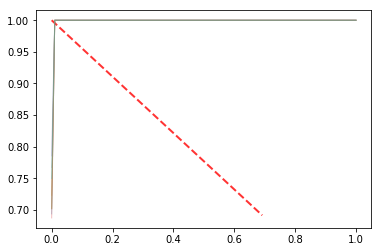

In [83]:
plot_pr_cv_folds_dbg(mean_tpr, prcs_AB, pr_aucs_AB, target, 'AdaBoost')


In [63]:
print(target)

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
450    1
451    1
452    1
453    1
454    1
455    1
456    1
457    1
458    1
459    1
460    1
461    1
462    1
463    1
464    1
465    1
466    1
467    1
468    1
469    1
470    1
471    1
472    1
473    1
474    1
475    1
476    1
477    1
478    1
479    1
Name: Loan_Status, Length: 480, dtype: int64


In [65]:
print(dir(target))

['T', '_AXIS_ALIASES', '_AXIS_IALIASES', '_AXIS_LEN', '_AXIS_NAMES', '_AXIS_NUMBERS', '_AXIS_ORDERS', '_AXIS_REVERSED', '_AXIS_SLICEMAP', '__abs__', '__add__', '__and__', '__array__', '__array_prepare__', '__array_priority__', '__array_wrap__', '__bool__', '__bytes__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__divmod__', '__doc__', '__eq__', '__finalize__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__

In [70]:
counts = target.value_counts()

In [73]:
print(counts[1])

332


In [72]:
len (target)

480

In [76]:
print((target == 1).sum())
print((target != 1).sum())

332
148


In [288]:
# AdaBoost GridSearch
# From https://stackoverflow.com/questions/32210569/using-gridsearchcv-with-adaboost-and-decisiontreeclassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

# param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
#               "base_estimator__splitter" :   ["best", "random"],
#               "n_estimators": [50, 100, 200],
#               "learning_rate": [0.8, 0.9, 1.0]
#              }

param_grid = {#"base_estimator" : ["SVC(probability=True, kernel='linear')", "DecisionTreeClassifier()"],
              "n_estimators": [50, 100, 200],
              "learning_rate": [0.9, 1.0]
             }


#DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)
#DTC = DecisionTreeClassifier()

svc=SVC(probability=True, kernel='linear')
dtc = DecisionTreeClassifier()
nb=GaussianNB()


ABC = AdaBoostClassifier(base_estimator=svc)

# run grid search
grid_search_ABC = GridSearchCV(ABC, cv=loan_folds, param_grid=param_grid)

In [289]:
#grid_search_ABC.fit(predictors, target)

In [290]:
#AB_classifier = AdaBoostClassifier()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_ABC, f1_scores_ABC, precisions_ABC, recalls_ABC, tprs_ABC, aucs_ABC, prcs_ABC, pr_aucs_ABC = evaluate_classifier_new(
                                                                        folds=loan_folds, 
                                                                        p=predictors, t=target, 
                                                                        classifier=grid_search_ABC, 
                                                                        mean_fpr=mean_fpr,
                                                                        mean_tpr=mean_tpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\mpower1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\mpower1

In [268]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_loans_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB, 'AdaBoost' : accuracies_AB,'AdaBoostC' : accuracies_ABC})

In [269]:
accuracies_loans_df.describe()

,SVM,Naive Bayes,AdaBoost,AdaBoostC
count,10.000000,10.000000,10.000000,10.000000
mean,0.808650,0.787732,0.779519,0.775522
std,0.042218,0.079246,0.045352,0.062465
min,0.755102,0.625000,0.708333,0.653061
25%,0.770833,0.770833,0.759035,0.743729
50%,0.803997,0.783588,0.789450,0.789450
75%,0.846631,0.834998,0.791667,0.807292
max,0.872340,0.893617,0.851064,0.854167


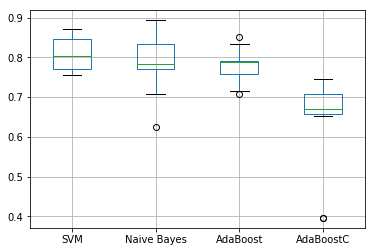

In [259]:
accuracies_loans_df.boxplot()